In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# VIT Model

## Import packages

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil

from tensorflow.keras.utils import image_dataset_from_directory
from PIL import Image
#import transformers

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms 
import torchvision.models as models 
from torch.utils.data import DataLoader
torch.manual_seed(46)

## Import data with Pytorch

In [4]:
data = pd.read_csv("/content/drive/MyDrive/Ocular_Disease_Recognition/raw_data/full_df.csv")

In [5]:
data['target_binary'] = (data['labels'] != "['N']").astype('int')

<AxesSubplot:xlabel='target_binary', ylabel='Count'>

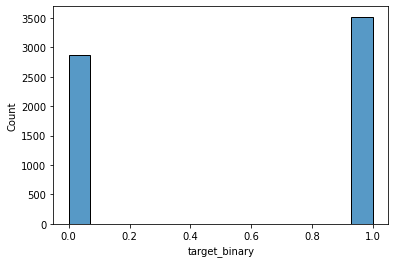

In [5]:
sns.histplot(data['target_binary'])

In [4]:
import pathlib
data_path = "/content/drive/MyDrive/Ocular_Disease_Recognition/data"
data_dir = pathlib.Path(data_path)

In [6]:
transforms_pipeline = transforms.Compose([
                                        transforms.Resize(256), # resize to smallest edge = 256
                                        transforms.CenterCrop(224), # center crop 224 x 224
                                        transforms.ToTensor(), # convert to tensor
                                        #transforms.Lambda(lambda t: t/255) # normalize 

                    ])

In [19]:
from torchvision import datasets, transforms
dataset = datasets.ImageFolder(data_path, transform=transforms_pipeline)
train_ds, test_ds = torch.utils.data.random_split(dataset, [5000, 1392])

In [20]:
train_dataloader = DataLoader(train_ds, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_ds, batch_size=1, shuffle=False)

## Model

In [9]:
# check device

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [10]:
vit16 = models.vit_b_16(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [11]:
# define model 

class Net(nn.Module):
    def __init__(self, pre_trained_model, out_channels):
        super().__init__()
        self.pretrained_model = pre_trained_model
        self.linear = nn.Linear(1000, out_channels)
        #self.classifier = nn.Linear(100, 1)

    def forward(self, x):
        x = self.pretrained_model(x)
        x = F.relu(x)
        x = self.linear(x)
        #logits = self.classifier(pooled_output)
        return x

In [12]:
# init my model 

model = Net(vit16, 1)

In [27]:
# some optimization variables

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
# define training function

def train(epochs):
    model.to(device)
    for epoch in range(epochs):
        print(f'Training epoch: {epoch + 1}..')
        losses = []
        for batch, (X, y) in enumerate(train_dataloader, start = 1):
            X = X.to(device)
            y = y.unsqueeze(1).float().to(device)
            optimizer.zero_grad()
            pred = model(X)
            #print(pred)
            loss = criterion(pred, y)
            #losses.append(loss.item())
            loss.backward()
            optimizer.step()

            if batch % 1 == 0:
                print(f'Processed batch {batch}..')

            # validate 
        with torch.no_grad():
            print(f'Evaluating on val set..')
            for Xv, yv in test_dataloader:
                Xv = Xv.to(device)
                yv = yv.unsqueeze(1).float().to(device)
                predv = model(Xv)
                lossv = criterion(predv, yv)
                losses.append(lossv.item())
        
        print("Validation Loss: ", np.mean(losses))
        print()

In [32]:
train(5)

Training epoch: 1..
tensor([[-0.1125],
        [-0.3190],
        [-0.4076],
        [-0.0273],
        [-0.0047],
        [ 0.1504],
        [-0.4266],
        [-0.1190],
        [ 0.0435],
        [-0.2688],
        [-0.1868],
        [ 0.0524],
        [-0.1069],
        [-0.1718],
        [ 0.0304],
        [ 0.0509]], grad_fn=<AddmmBackward0>)
Processed batch 1..
tensor([[-0.3178],
        [-0.3083],
        [-0.3965],
        [-0.1762],
        [-0.3234],
        [-0.4544],
        [-0.2328],
        [-0.2639],
        [-0.1916],
        [-0.0711],
        [ 0.2275],
        [-0.2042],
        [-0.1492],
        [-0.2909],
        [-0.1437],
        [-0.3479]], grad_fn=<AddmmBackward0>)
Processed batch 2..
tensor([[-0.2966],
        [-0.3669],
        [-0.3364],
        [-0.2451],
        [-0.0398],
        [ 0.2827],
        [-0.2094],
        [-0.1915],
        [-0.3108],
        [-0.0043],
        [-0.2244],
        [ 0.0999],
        [-0.0838],
        [-0.2754],
        [-0.

KeyboardInterrupt: ignored